In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [23]:
df = pd.read_csv('data/train_motion_data.csv')

In [24]:
from imblearn.over_sampling import RandomOverSampler

# 특징과 타깃 분리 (타깃 컬럼: "Class")
X = df.drop(columns=['Class'])
y = df['Class']

# RandomOverSampler를 사용해 클래스 비율 균형 맞추기
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

# 균형 잡힌 데이터를 다시 하나의 DataFrame으로 결합
df_balanced = X_res.copy()
df_balanced['Class'] = y_res

# 균형 잡힌 데이터를 새로운 CSV 파일로 저장
df_balanced.to_csv('data/train_motion_data_balanced.csv', index=False)

In [25]:
df_balanced['Class'].value_counts()

Class
NORMAL        1331
AGGRESSIVE    1331
SLOW          1331
Name: count, dtype: int64

In [26]:
df = df_balanced

In [27]:
df['Class'].value_counts()

Class
NORMAL        1331
AGGRESSIVE    1331
SLOW          1331
Name: count, dtype: int64

# 학습

In [45]:
class DrivingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# 시퀀스 생성 함수
def create_sequences(data, labels, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(labels[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 50


# timestamp 기준 정렬
df = df.sort_values(by='Timestamp').reset_index(drop=True)

# 라벨 인코딩
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])  # AGGRESSIVE=0, NORMAL=1, SLOW=2

# 피처 선택
feature_cols = [col for col in df.columns if col not in ['Timestamp', 'Class']]
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

X, y = create_sequences(df[feature_cols].values, df['Class'].values, SEQ_LEN)

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = DrivingDataset(X_train, y_train)
val_dataset = DrivingDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 클래스 가중치 계산 (원본 훈련 데이터 기준)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=4):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.dropout(hn[-1])  # 마지막 hidden state
        out = self.fc(out)
        return out

input_dim = X.shape[2]
hidden_dim = 64
output_dim = len(np.unique(y))

model = LSTMClassifier(input_dim, hidden_dim, output_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 가중치 적용한 loss 함수 (GPU 사용 시 to(device) 적용)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

EPOCHS = 30

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")
    
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())
        
target_names = ['0', '1', '2']
print(classification_report(all_labels, all_preds, target_names=target_names))

Epoch [1/30], Loss: 1.0987
Epoch [2/30], Loss: 1.0076
Epoch [3/30], Loss: 0.9494
Epoch [4/30], Loss: 0.9860
Epoch [5/30], Loss: 0.8895
Epoch [6/30], Loss: 0.8248
Epoch [7/30], Loss: 0.8038
Epoch [8/30], Loss: 0.7692
Epoch [9/30], Loss: 0.7329
Epoch [10/30], Loss: 0.7398
Epoch [11/30], Loss: 0.6288
Epoch [12/30], Loss: 0.5663
Epoch [13/30], Loss: 0.4998
Epoch [14/30], Loss: 0.4691
Epoch [15/30], Loss: 0.4324
Epoch [16/30], Loss: 0.4300
Epoch [17/30], Loss: 0.3686
Epoch [18/30], Loss: 0.3467
Epoch [19/30], Loss: 0.3556
Epoch [20/30], Loss: 0.3679
Epoch [21/30], Loss: 0.3097
Epoch [22/30], Loss: 0.2738
Epoch [23/30], Loss: 0.2555
Epoch [24/30], Loss: 0.2385
Epoch [25/30], Loss: 0.2299
Epoch [26/30], Loss: 0.2164
Epoch [27/30], Loss: 0.2103
Epoch [28/30], Loss: 0.2296
Epoch [29/30], Loss: 0.1927
Epoch [30/30], Loss: 0.1890
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       262
           1       0.99      0.84      0.91       276
      

# Test 데이터 성능

📊 Independent Test Set Performance:
              precision    recall  f1-score   support

           0       0.60      0.77      0.67       764
           1       0.50      0.51      0.50       997
           2       0.77      0.62      0.69      1273

    accuracy                           0.62      3034
   macro avg       0.62      0.63      0.62      3034
weighted avg       0.64      0.62      0.62      3034



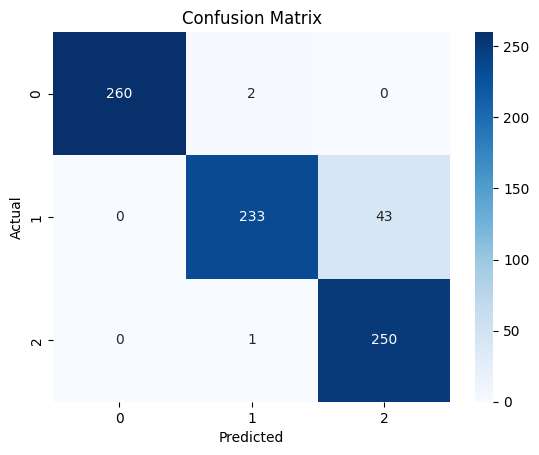

In [47]:
from sklearn.metrics import classification_report, confusion_matrix

# 테스트 데이터 로드
test_df = pd.read_csv('data/test_motion_data.csv')

# timestamp 기준 정렬
test_df = test_df.sort_values(by='Timestamp').reset_index(drop=True)

# 클래스 라벨 인코딩 (train에서 사용한 label encoder 그대로)
test_df['Class'] = le.fit_transform(test_df['Class'])  # le: 기존 LabelEncoder

# 피처 정규화 (train에서 학습한 scaler 사용)
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

X_test, y_test = create_sequences(test_df[feature_cols].values, test_df['Class'].values, SEQ_LEN)

# PyTorch Dataset & DataLoader
test_dataset = DrivingDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_test_preds.extend(preds)
        all_test_labels.extend(y_batch.numpy())

print("📊 Independent Test Set Performance:")
print(classification_report(all_test_labels, all_test_preds, target_names=target_names))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 성능 개선 1 - 0.67

In [45]:
class DrivingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class CustomFocalLoss(nn.Module):
    """Pytorch로 만든 Focal 손실함수(Cross-Entropy와 가중치 주는 기능이 추가된 거라 보면 됨)"""
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(CustomFocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha) if alpha is not None else None
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)

        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)[targets]
            focal_loss = alpha * (1 - pt) ** self.gamma * ce_loss
        else:
            focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


def create_sequences(data, labels, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(labels[i+seq_len])
    return np.array(X), np.array(y)


SEQ_LEN = 50 # 일단 지금으로서는 이게 제일 적절해보임요


df = df.sort_values(by='Timestamp').reset_index(drop=True)

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])  # AGGRESSIVE=0, NORMAL=1, SLOW=2

feature_cols = [col for col in df.columns if col not in ['Timestamp', 'Class']]
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

X, y = create_sequences(df[feature_cols].values, df['Class'].values, SEQ_LEN)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = DrivingDataset(X_train, y_train)
val_dataset = DrivingDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class LSTMClassifier(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2): # 왜인지 모르겠는데 num_layer 높일수록 성능은 저하됨..
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True) # 일단 지금은 양방향 LSTM 쓰고 있는 상태
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        hn_forward = hn[-2]
        hn_backward = hn[-1]
        out = torch.cat((hn_forward, hn_backward), dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        return out


input_dim = X.shape[2]
hidden_dim = 64
output_dim = len(np.unique(y))

model = LSTMClassifier(input_dim, hidden_dim, output_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = CustomFocalLoss(alpha=[1.0, 2.0, 1.0], gamma=2.0)  # 클래스 1에 가중치를 더 준다.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")
    
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())
        
target_names = ['0', '1', '2']
print(classification_report(all_labels, all_preds, target_names=target_names))

Epoch [1/20], Loss: 0.6123
Epoch [2/20], Loss: 0.5751
Epoch [3/20], Loss: 0.4409
Epoch [4/20], Loss: 0.3158
Epoch [5/20], Loss: 0.2402
Epoch [6/20], Loss: 0.1874
Epoch [7/20], Loss: 0.1698
Epoch [8/20], Loss: 0.1523
Epoch [9/20], Loss: 0.1505
Epoch [10/20], Loss: 0.1225
Epoch [11/20], Loss: 0.1007
Epoch [12/20], Loss: 0.1000
Epoch [13/20], Loss: 0.0853
Epoch [14/20], Loss: 0.0615
Epoch [15/20], Loss: 0.0508
Epoch [16/20], Loss: 0.0381
Epoch [17/20], Loss: 0.0312
Epoch [18/20], Loss: 0.0355
Epoch [19/20], Loss: 0.0487
Epoch [20/20], Loss: 0.0131
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       262
           1       0.99      0.97      0.98       276
           2       0.97      1.00      0.98       251

    accuracy                           0.99       789
   macro avg       0.99      0.99      0.99       789
weighted avg       0.99      0.99      0.99       789



## 성능 테스트 1

📊 Independent Test Set Performance:
              precision    recall  f1-score   support

           0       0.61      0.88      0.72       764
           1       0.60      0.24      0.35       997
           2       0.70      0.85      0.77      1273

    accuracy                           0.66      3034
   macro avg       0.64      0.66      0.61      3034
weighted avg       0.65      0.66      0.62      3034



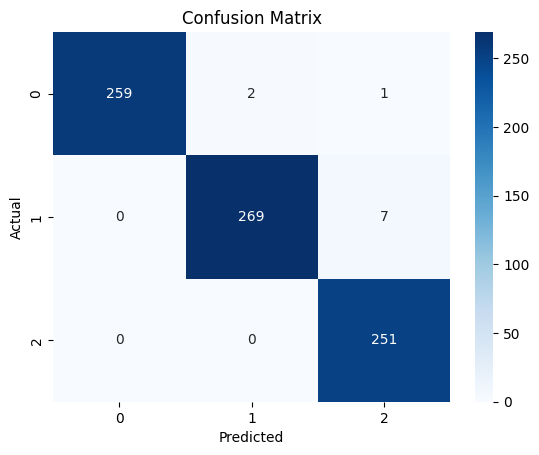

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

"""현재 클래스1 Normal을 잘 맞추기 있지 못함. 클래스 0, 2는 잘 맞추는 상태. 분석해본 결과로는 클래스 1인 Normal은 너무 평범한 데이터들이라 자꾸 클래스 2로
    오분류 하는 거 같음. 따라서 지피티는 가속의 변화량, 자이로 변화량 같은 피처를 더 추가해서 변화량이 미미하면 Normal, 변화량이 크거나 작으면 slow나 agressive 이런 식으로
    더 잘 학습할 수 있게 해보는 건 어떠냐고 추천 중.. -> 해보긴 했는데 기대한 만큼 나오진 않음."""

# 테스트 데이터 로드
test_df = pd.read_csv('data/test_motion_data.csv')

# timestamp 기준 정렬
test_df = test_df.sort_values(by='Timestamp').reset_index(drop=True)

# 클래스 라벨 인코딩 (train에서 사용한 label encoder 그대로)
test_df['Class'] = le.fit_transform(test_df['Class'])  # le: 기존 LabelEncoder

# 피처 정규화 (train에서 학습한 scaler 사용)
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

X_test, y_test = create_sequences(test_df[feature_cols].values, test_df['Class'].values, SEQ_LEN)

# PyTorch Dataset & DataLoader
test_dataset = DrivingDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_test_preds.extend(preds)
        all_test_labels.extend(y_batch.numpy())

print("📊 Independent Test Set Performance:")
print(classification_report(all_test_labels, all_test_preds, target_names=target_names))

cm = confusion_matrix(all_labels, all_preds) # 혼동 행렬 : 어느 클래스가 자꾸 어느 쪽으로 오분류 되는지 알려줌 -> FocalLoss로 줄이긴 했으니 recall이 여전히 낮음
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [3]:
import pandas as pd

df = pd.read_csv('data/new_train_motion_data.csv')
df.head()

,Unnamed: 0,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class
0,0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,0
1,1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,0
2,2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,0
3,3,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,0
4,4,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,0


In [4]:
train = pd.read_csv('data/new_train_motion_data.csv', index_col=0)
train

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class
0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,0
1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,0
2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,0
3,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,0
4,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,0
...,...,...,...,...,...,...,...
2308,0.538870,-1.645984,-0.712197,0.349568,0.028100,0.662712,1
2309,1.678918,-1.392127,-0.476326,0.570090,-0.061697,-0.168675,1
2310,0.323433,0.589311,-1.939797,-0.027947,1.255328,0.639500,1
2311,2.497311,-0.606175,4.700154,0.849255,-0.196699,-0.240757,1


In [6]:
train.value_counts('Class')

Class
0    1200
1    1113
Name: count, dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2313 entries, 0 to 2312
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AccX    2313 non-null   float64
 1   AccY    2313 non-null   float64
 2   AccZ    2313 non-null   float64
 3   GyroX   2313 non-null   float64
 4   GyroY   2313 non-null   float64
 5   GyroZ   2313 non-null   float64
 6   Class   2313 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 144.6 KB


In [12]:
train.groupby('Class').mean()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
Class,,,,,,
0,-0.017973,-0.027739,0.034425,0.001905,-0.000916,0.009527
1,0.096086,-0.170461,-0.021144,0.000230,-0.002886,0.011099
